In [1]:
%%capture
!pip install datasets
!pip install tokenizers==0.10.0rc1
!pip install wandb
!pip install stop_words

In [2]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import datasets
import tokenizers
import wandb
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from stop_words import get_stop_words
from string import punctuation

## О формате заданий

### Coding tasks


Место для вашего кода отмечено блоками `# YOUR CODE STARTS` ... `#YOUR CODE ENDS` и ваше решение должно быть строго между ними.

Чтобы решить задачу, вам придётся смотреть в документацию соответствующего фреймворка. Этот навык очень важен, и в начале мы будем намекать вам на название метода, который вам нужно использовать. Такой подход позволит плавно приблизить вас к более реалистичным задачам.



![image.png](https://files.realpython.com/media/Practical-Text-Classification-with-Keras-and-Python_Watermark.fe326bd75146.jpg)

Image source: [тык](https://realpython.com/python-keras-text-classification/)

In [3]:
text_dataset = datasets.load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

**IMDB** - это датасет по классификации эмоциональной окраски. Вам нужно предсказать положительный ли отзыв к фильму по его тексту. Это довольно простая задача и она хорошо решается даже линейными моделями. Для доступа к нему мы используем библиотеку `datasets` - она содержит в себе много интересных текстовых датасетов.

Тренировочная и тстовая части IMDB достаточно большие - каждая состоит из 25 тысяч примеров.

In [4]:
text_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
type(text_dataset)

datasets.dataset_dict.DatasetDict

Как мы видим, классы сбалансированны, что позволяет использовать accuracy как простую и интерпретируемую метрику, хорошо показывающую качество модели.

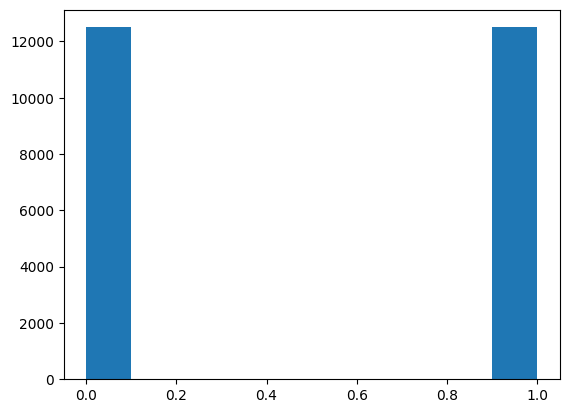

In [6]:
train_labels = [e['label'] for e in text_dataset['train']]
plt.hist(train_labels)
plt.show()

In [7]:
text_dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

# Classification using a linear model

Линейная модель - очень сильный бейзлайн и в некоторых задачах классификации вам даже не надо идти дальше линейной модели - она уже достаточно хороша. А также её можно написать менее чем в 10 строчекю Поэтому всегда стоит начинать решение любой задачи с ленейного бейзлайна.

Давайте вспомним библиотеку `sklearn` и напишем линейную модельку. Для векторизации текста мы будем использовать `TfidfVectorizer`, а в качестве модели `LogisticRegression`.


In [8]:
# TASK 1.1: create TfidfVectorizer object and fit it on out training set texts
# Our implementation is 2 lines
# YOUR CODE STARTS

vectorizer = TfidfVectorizer()

# YOUR CODE ENDS

In [9]:
# TASK 1.2:
# 1. convert your texts to tf-idf vectors using .transform (training texts and test texts too)
# 2. convert your labels into numpy arrays (both training and test labels)
# Or implementatin is 4 lines

# YOUR CODE STARTS

X_train = np.array(text_dataset['train']['text'])
y_train = np.array(text_dataset['train']['label'])

X_test = np.array(text_dataset['test']['text'])
y_test = np.array(text_dataset['test']['label'])

# YOUR CODE ENDS

In [10]:
# С данной предобработкой результат хуже

# Данная предобработка приводит к нижнему регистру и удаляет знаки пунктуации и "мусорные слова"

# def tras_p_w(x):

#     x = x.lower()
#     x = "".join(i for i in x if i not in punctuation)
#     x = " ".join(word for word in x.split() if word not in set(get_stop_words('en')))

#     return x


# trans = np.vectorize(tras_p_w)

# X_train = trans(X_train)
# X_test = trans(X_test)

In [11]:
# можно попробовать просто привести к нижнему регистру и посмотреть как отработает

trans = np.vectorize(lambda x: x.lower())

X_train = trans(X_train)
X_test = trans(X_test)

In [12]:
# можно попробовать просто убрать знаки пунктуации

trans = np.vectorize(lambda x: "".join(i for i in x if i not in punctuation))

X_train = trans(X_train)
X_test = trans(X_test)

In [13]:
# X_train, X_test

In [14]:
X_train = vectorizer.fit_transform(X_train)

X_test = vectorizer.transform(X_test)

In [15]:
X_train, y_train

(<25000x120674 sparse matrix of type '<class 'numpy.float64'>'
 	with 3465353 stored elements in Compressed Sparse Row format>,
 array([0, 0, 0, ..., 1, 1, 1]))

In [16]:
# TASK 1.3: create LogisticRegression model object and fit the model
# Our implementation is 2 lines
# YOUR CODE STARTS

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train )

# YOUR CODE ENDS

LogisticRegression()

А теперь мы используем нашу модель для того, чтобы предсказать классы на тестовом сете и считаем accuracy.

In [17]:
predictions = model_lr.predict(X_test)

print(type(predictions))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [18]:
# note that we can use vector operations, because we deal with numpy tensors
accuracy = (predictions == y_test).mean()
accuracy

0.88328

**OMG so accurate, much machine learning**

Давайте предскажем позитивны ли такие комментарии:

In [19]:
positive_comment = 'This movie is awesome!'

vec = vectorizer.transform([positive_comment])
model_lr.predict(vec)

array([1])

In [20]:
negative_comment = 'This movie is awful!'

vec = vectorizer.transform([negative_comment])
model_lr.predict(vec)

array([0])

Как мы увидели, даже такая простая модель может хорошо классифицировать текст (accuracy 0.9 - это довольно много, тк выборка сбалансированна).

Кстати, использование модели LinearSVM обычно работает даже лучше, чем логистическая регрессия. Рекомендуем попробовать и сравнить.

Что такое SVM: [тык](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)

Ещё один простой метод улучшить линейную модель - использовать n-gram в вашем TF-IDF. Не забудьте указать параметр `max_features` (хорошое число 50 000), а то при большом количестве фичей модель может начать переобучаться.

In [21]:
# Модель SVC

model_svc = SVC()
model_svc.fit(X_train,y_train)

SVC()

In [22]:
y_pred = model_svc.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.88776


In [23]:
# Ещё один простой метод улучшить линейную модель - использовать n-gram в вашем TF-IDF.
# Не забудьте указать параметр max_features (хорошое число 50 000), а то при большом количестве фичей модель может начать переобучаться.

vectorizer_ng = TfidfVectorizer(max_features = 50000, ngram_range = (1,3))

X_train = np.array(text_dataset['train']['text'])
y_train = np.array(text_dataset['train']['label'])

X_test = np.array(text_dataset['test']['text'])
y_test = np.array(text_dataset['test']['label'])


# можно попробовать просто привести к нижнему регистру

trans = np.vectorize(lambda x: x.lower())

X_train = trans(X_train)
X_test = trans(X_test)

# можно попробовать просто убрать знаки пунктуации

trans = np.vectorize(lambda x: "".join(i for i in x if i not in punctuation))

X_train = trans(X_train)
X_test = trans(X_test)



X_train = vectorizer_ng.fit_transform(X_train)
X_test = vectorizer_ng.transform(X_test)


model_lr = LogisticRegression()
model_lr.fit(X_train, y_train )


predictions = model_lr.predict(X_test)

print(type(predictions))
print(type(y_test))


accuracy = (predictions == y_test).mean()
accuracy

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.8946